# Variational Linear Regression

This notebook shows how to implement the variational linear regression model with optimized output value variance according to the derivation in PRML.

Application of the model is demonstrated using samples generated by a sinusoidal function with Gaussian noise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from sklearn import preprocessing

np.random.seed(seed=0)

# Data

The data consists of 1D input features $x$ paired with a observed noisy target value $y$.

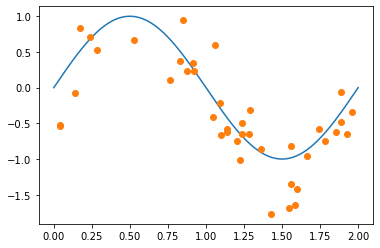

In [2]:
obs_N = 40
x_range_min = 0.
x_range_max = 2.
x = np.random.random(obs_N) * (x_range_max - x_range_min)

t_var = 0.4
t_noise = np.random.normal(scale=t_var, size=obs_N)

t = np.zeros(obs_N)

for i in range(obs_N):
    t[i] = np.sin(x[i] * np.pi) + t_noise[i]

x_dense = np.linspace(x_range_min, x_range_max, 200)
y_true = np.sin(np.pi*x_dense)
plt.plot(x_dense, y_true)
plt.plot(x, t, 'o')
plt.show()

### Linear basis function model

Applying a fixed nonlinear transformation on the input variable vectors $x$ to generate feature vectors $\phi$, allowing the model to consider linear combinations of fixed nonlinear functions of the input variables.

$\phi^{(n)} = (\phi_1(x^{(n)}), \dots, \phi_N(x^{(n)})), \:\:\: where \: \phi_j = f(x)$

The dataset features are represented as an (I,N) array with with each column $n$ corresponding to a feature vector $\phi^{(n)}$.

<table style="border:1">
    <tr>
        <td>$\phi^{(1)}_1$</td>
        <td>$\phi^{(2)}_1$</td>
        <td>$\dots$</td>
        <td>$\phi^{(N)}_1$</td>
    </tr>
    <tr>
        <td>$\phi^{(1)}_2$</td>
        <td>$\phi^{(2)}_2$</td>
        <td>$\dots$</td>
        <td>$\phi^{(N)}_2$</td>
    </tr>
    <tr>
        <td>$\dots$</td>
        <td>$\dots$</td>
        <td>$\dots$</td>
        <td>$\dots$</td>
    </tr>
    <tr>
        <td>$\phi^{(1)}_I$</td>
        <td>$\phi^{(2)}_I$</td>
        <td>$\dots$</td>
        <td>$\phi^{(N)}_I$</td>
    </tr>
</table>

In [3]:
def input2feature(x, mean, std):
    '''Returns a feature vector 'phi' by transforming input vector 'x' according to a basis function.
    
    Args:
        input_vec: Input vector of shape (m,1).
        mean: Vector with mean value of all input vec features.
        std: Vector with standard deviation values of all input vec features.
        
    Returns:
        feat_vec: Feature vector of shape(d,1).
    '''
    # Normalize input vector w. standard deviation 1 
    input_vec = (x - mean) / std
    
    input_vec = np.array(input_vec)
    
    feat_vec = np.zeros((4,1), dtype=np.float)
    
    feat_vec[0,0] = input_vec
    feat_vec[1,0] = input_vec**2
    feat_vec[2,0] = input_vec**3
    feat_vec[3,0] = 1.0
    
    return feat_vec

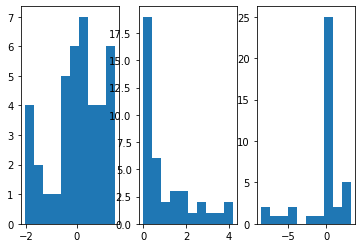

Before normalization (mean, std)
phis[0,:] (1.3322676295501878e-16, 1.0)
phis[1,:] (1.0, 1.1973021535377086)
phis[2,:] (-0.5151928971503204, 2.6832374204942595)


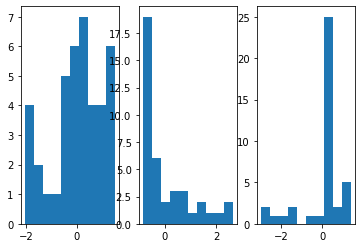

After normalization (mean, std)
phis[0,:] (1.1102230246251566e-17, 1.0)
phis[1,:] (-6.661338147750939e-17, 1.0)
phis[2,:] (-3.3306690738754695e-17, 1.0)


In [4]:
############################################
#  TRANSFORM 'INPUT VEC' -> 'FEATURE VEC'
############################################
# Empty 'Phi' matrix with #features according to basis function
phis = np.zeros((input2feature(x[0], 1., 1.).shape[0], obs_N))

# Compute feature vectors one-by-one
mean = np.mean(x)
std = np.std(x)
for n in range(obs_N):
    phis[:,n:n+1] = input2feature(x[n], mean, std)
    
# Unnormalized features
plt.subplot(1,3,1)
plt.hist(phis[0,:], bins=10)
plt.subplot(1,3,2)
plt.hist(phis[1,:], bins=10)
plt.subplot(1,3,3)
plt.hist(phis[2,:], bins=10)
plt.show()
print("Before normalization (mean, std)")
print(f"phis[0,:] ({np.mean(phis[0,:])}, {np.std(phis[0,:])})")
print(f"phis[1,:] ({np.mean(phis[1,:])}, {np.std(phis[1,:])})")
print(f"phis[2,:] ({np.mean(phis[2,:])}, {np.std(phis[2,:])})")

##############################
#  NORMALIZE FEATURE MATRIX
##############################
# 'X' matrix needs dimension (samples, features)
basis_scaler = preprocessing.StandardScaler().fit(phis.T)
phis = basis_scaler.transform(phis.T).T
# Recover bias term (as it gets normalized by the scaler)
phis[-1,:] = 1.

# Normalized features
plt.subplot(1,3,1)
plt.hist(phis[0,:], bins=10)
plt.subplot(1,3,2)
plt.hist(phis[1,:], bins=10)
plt.subplot(1,3,3)
plt.hist(phis[2,:], bins=10)
plt.show()
print("After normalization (mean, std)")
print(f"phis[0,:] ({np.mean(phis[0,:])}, {np.std(phis[0,:])})")
print(f"phis[1,:] ({np.mean(phis[1,:])}, {np.std(phis[1,:])})")
print(f"phis[2,:] ({np.mean(phis[2,:])}, {np.std(phis[2,:])})")

# Number of features
D = phis.shape[0]

ts = np.zeros((obs_N,1))
ts[:,0] = t

### Labels

Stored as an (1,N) array with each column $n$ corresponding to label $t$ of example $n$.

<table style="border:1">
    <tr>
        <td>$y^{(1)}$</td>
        <td>$y^{(2)}$</td>
        <td>$\dots$</td>
        <td>$y^{(N)}$</td>
    </tr>
</table>

### Summary of data

In [5]:
print(f"Feature array 'phis' : {phis.shape}")
print(f"Label array 'ts'     : {ts.shape}")
print(f"    #Samples  : {obs_N}")
print(f"    #Features : {D}")

Feature array 'phis' : (4, 40)
Label array 'ts'     : (40, 1)
    #Samples  : 40
    #Features : 4


# Expectations

In [6]:
def alpha_expectation(a_N, b_N):
    '''Returns the expected value of a Gamma distribution defined by parameters 'a_N' and 'b_N'.
    
    Ref: Bishop Eq 10.102 (p.488)
    '''
    return a_N / b_N


def beta_expectation(c_N, d_N):
    '''Returns the expected value of a Gamma distribution defined by parameters 'c_N' and 'd_N'.
    
    Ref: Equiv. to Bishop Eq 10.102 (p.488)
    '''
    return c_N / d_N


def gaussian_quadratic_expectation_wrt_w(mu_N, sigma_N):
    '''Returns the expected value of the quadratic weight vectors for a Gaussian distribution w.r.t. weights.
    
    Because we are taking the expectations w.r.t. weights, other unrelated terms can be dropped from the general expectation.
    
    Ref: Bishop Eq 10.183 (p.505)
    '''
    return np.matmul(mu_N.T, mu_N) + np.trace(sigma_N)

# Maximization (re-estimation) equations

$$q^*(w) = \mathcal{N}( w | \mu_N, \Sigma_N )$$

where

$${\mu}_N = \mathbb{E}[\beta] \: \Sigma_N \Phi^T t$$

$$\Sigma_N = \left( \mathbb{E}[\beta] \: \Phi^T \Phi + \mathbb{E}[\alpha] \: I \right)^{-1}$$

In [7]:
def estim_qw_distr(phis, ts, exp_alpha, exp_beta):
    '''Returns parameters for the re-estimated distribution which maximizes the lower bound.
    
    Args:
        phis:   : Feature matrix of shape (D,N).
        ts      : Label vector of shape (1,N).
        exp_alpha : Expected value of Gamma distribution modeling variance of 'p(w)'.
        exp_beta  : Expected value of Gamma distribution modeling variance of 'p(t)'.
        
    Returns:
        mu_N, sigma_N : Mean vector and covariance matrix of shapes (D,1) and (D,D).
    
    Ref: Bishop Eq. 10.96-10.98 (p.487)
    '''
    sigma_N = exp_beta * phis.T.dot(phis) + exp_alpha * np.eye(phis.shape[1])
    sigma_N = np.linalg.inv(sigma_N)
    
    mu_N = exp_beta * sigma_N.dot(phis.T).dot(ts)
    
    return mu_N, sigma_N

$$q^*(\alpha) = Gam(\alpha | a_N, b_N)$$

where

$$a_N = a_0 + \frac{D}{2}$$

$$b_N = b_0 + \frac{1}{2}  \mathbb{E}[w^T w]$$

In [8]:
def estim_qalpha_distr(a_0, b_0, exp_quad_w, D):
    '''Returns parameters for the re-estimated distribution which maximizes the lower bound.
    
    Args:
        a_0 : Value of initial variational hyperpriors for alpha distr.
        b_0 : 
        exp_quad_w : The expected value of the quadratic weight vectors for a Gaussian distribution w.r.t. weights.
        D : Number of model parameters (i.e. length of mu_N).
        
    Returns:
        a_N, b_N : Scalar parameters.
        
    Ref: Bishop Eq. 10.93-10.95 (p.487)
    '''
    a_N = a_0 + 0.5*D
    b_N = b_0 + 0.5*exp_quad_w
    
    return a_N, b_N

$$q^*(\beta) = Gam(\beta | c_N, d_N)$$

where

$$c_N = c_0 + \frac{N}{2}$$

$$d_N = d_0 + \frac{1}{2} \left( || \Phi \mu_N - t ||^2 + Tr[\Phi^T \Phi \Sigma_N] \right)$$

In [9]:
def estim_qbeta_distr(c_0, d_0, phis, ts, mu_N, sigma_N, N):
    '''Returns parameters for the re-estimated distribution which maximizes the lower bound.
    
    Args:
        c_0     : Value of initial variational hyperpriors for beta distr.
        d_0     : 
        phis    : Feature matrix of shape (D,N).
        ts      : Label vector of shape (1,N).
        mu_N    : Mean vector for weight distribution 'q(w)' of shape (D,1).
        sigma_N : Covariance matrix for weight distribution 'q(w)' of shape (D,D).
        N       : Number of samples (i.e. observations).
    
    Returns:
        c_N, d_N : Scalar parameters.
    '''
    c_N = c_0 + 0.5*N
    d_N = d_0 + 0.5*(np.linalg.norm(phis.dot(mu_N) - ts)**2 + np.trace(phis.T.dot(phis).dot(sigma_N)))
    
    return c_N, d_N

# Expectation Maximization iteration

In [10]:
def comp_lower_bound(phis, ts, mu_N, sigma_N, beta, a_0, b_0, c_0, d_0, a_N, b_N, c_N, d_N, D, N, eps=1e-14):
        # Exp[ log p(t|w) ]_{w}
        term_1 = 0.5 * N * np.log(beta / (2.*np.pi) + eps) - 0.5 * beta * ts.T.dot(ts) + beta * mu_N.T.dot(phis.T).dot(ts) - 0.5 * beta * np.trace(phis.T.dot(phis).dot( mu_N.dot(mu_N.T) + sigma_N ))
        # Exp[ log p(w|alpha) ]_{w, alpha}
        term_2 = -0.5 * D * np.log(2.*np.pi) + 0.5*D*(special.digamma(a_N) - np.log(b_N + eps)) - (a_N / (2.*b_N)) * (mu_N.T.dot(mu_N) + np.trace(sigma_N))
        # Exp[ log p(alpha) ]_{alpha}
        term_3 = a_0 * np.log(b_0 + eps) + (a_0 - 1.)*(special.digamma(a_N) - np.log(b_N + eps)) - b_0*(a_N/b_N) - np.log(special.gamma(a_N) + eps)
        # Exp[ log p(beta) ]_{beta}
        term_4 = c_0 * np.log(d_0 + eps) + (c_0 - 1.)*(special.digamma(c_N) - np.log(d_N + eps)) - d_0*(c_N/d_N) - np.log(special.gamma(c_N) + eps)
        # Exp[ log q(w) ]_{w}
        term_5 = -0.5*np.log(np.linalg.det(sigma_N) + eps) - 0.5*D*(1. + np.log(2.*np.pi))
        # Exp[ log q(alpha) ]_{alpha}
        term_6 = -np.log(special.gamma(a_N) + eps) + (a_N - 1.)*special.digamma(a_N) + np.log(b_N + eps) - a_N
        # Exp[ log q(beta) ]_{beta}
        term_7 = -np.log(special.gamma(c_N) + eps) + (c_N - 1.)*special.digamma(c_N) + np.log(d_N + eps) - c_N
        lower_bound = term_1 + term_2 + term_3 + term_4 - term_5 - term_6 - term_7
        # Return scalar
        return lower_bound.item()

In [11]:
# Model formulated in terms of a (N, D) feature matrix
phis = phis.T

iter 1 | -93.31967629280847
iter 2 | -76.70874381806797
iter 3 | -73.66081693080513
iter 4 | -73.43331919788142
iter 5 | -73.3893649711834
iter 6 | -73.38667166429511
iter 7 | -73.38478797935565
iter 8 | -73.3847117013575
iter 9 | -73.3845701263671
iter 10 | -73.38456401419923
iter 11 | -73.38455217663335
iter 12 | -73.3845515630076
Converged

Lower bound converges to a maximum (higher lower bound ==> better approximation)


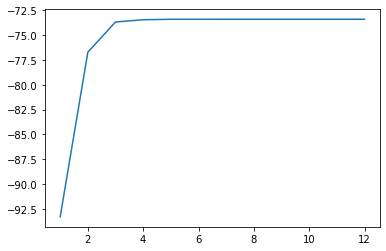

In [12]:
#######################
#  Initial variables
#######################

# Hyperpriors for Gamma distributions
a_0 = 1.
b_0 = 1.
c_0 = 1.
d_0 = 1.

a_N = a_0
b_N = b_0
c_N = c_0
d_N = d_0

mu_N = np.random.random((D,1))
sigma_N = np.eye(D)

lower_bound_prev = np.inf
lower_bound_list = []

conv_criteria = 1e-6

for iter_idx in range(1,201):
    
    # Expectation step
    exp_alpha = alpha_expectation(a_N, b_N)
    exp_beta = beta_expectation(c_N, d_N)
    exp_quad_w = gaussian_quadratic_expectation_wrt_w(mu_N, sigma_N)
    
    # Maximization step
    mu_N, sigma_N = estim_qw_distr(phis, ts, exp_alpha, exp_beta)
    a_N, b_N = estim_qalpha_distr(a_0, b_0, exp_quad_w, D)
    c_N, d_N = estim_qbeta_distr(c_0, d_0, phis, ts, mu_N, sigma_N, obs_N)
    
    # Lower bound
    lower_bound = comp_lower_bound(phis, ts, mu_N, sigma_N, exp_beta, a_0, b_0, c_0, d_0, a_N, b_N, c_N, d_N, D, obs_N)
    lower_bound_list.append((iter_idx, lower_bound))
    
    if iter_idx % 1 == 0:
        print(f"iter {iter_idx} | {lower_bound}")
    
    # Check convergence
    if (np.abs(lower_bound - lower_bound_prev) < conv_criteria):
        print("Converged")
        break
    else:
        lower_bound_prev = lower_bound
    
# Plot lower bound convergence
iters = [entry[0] for entry in lower_bound_list]
lower_bounds = [entry[1] for entry in lower_bound_list]
print("\nLower bound converges to a maximum (higher lower bound ==> better approximation)")
plt.plot(iters, lower_bounds)
plt.show()

# Predictive posterior $p(t^{new} | \phi^{new}, \mathbb{D})$

In [13]:
def predictive_posterior_distr(x, mu_N, sigma_N, beta, basis_func, input_data_mean, input_data_std, basis_scaler):
    '''Computes the probability distribution representing the output value of a feature vector.
    
    Args:
        x: Input vector of shape (m,1).
        mu_N: Mean vector for weight distribution 'q(w)' of shape (D,1).
        sigma_N: Covariance matrix for weight distribution 'q(w)' of shape (D,D).
        beta: Precision value for output value distribution (i.e. observation noise).
        basis_func: Nonlinear function which transforms input vec --> feature vec.
        input_data_mean: Vector with mean value of all input vec features.
        input_data_std: Vector with standard deviation values of all input vec features.
        basis_scaler: Object with parameters for normalizing all feature vectors with std 1.
    
    Returns:
        mu, sigma2: Gaussian distribution parameters representing the predicted data generating process (output value 'y' given input 'x').
    '''
    # Transform 'input vec' --> 'feat vec'
    phi = basis_func(x, input_data_mean, input_data_std)
    # Normalize 'feat vec' similar to training
    phi = basis_scaler.transform(phi.T).T
    # Recover bias term (as it gets normalized by the scaler)
    phi[-1,:] = 1.
    
    mu = mu_N.T.dot(phi)
    sigma2 = 1./beta + phi.T.dot(sigma_N).dot(phi)
    return mu, sigma2

Predicted output value precision 'beta': 6.146449912507832
Predicted output value variance 'sigma: 0.4033553545171834 (true: 0.4)

Predicted distribution and true distribution overlayed by observations


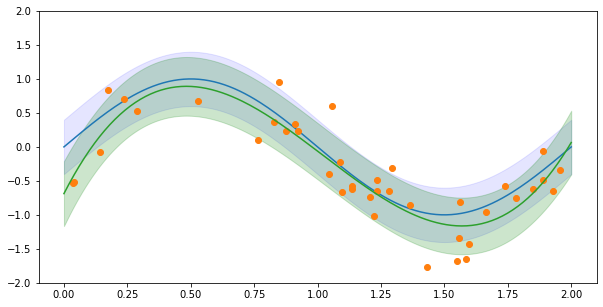


Combined parameter and model output variance


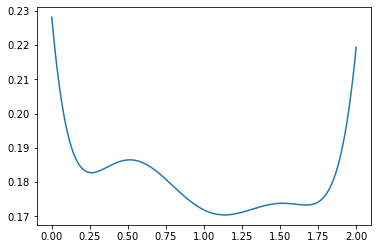


Weight distribution covariance matrix (shape: (4, 4))
[[ 2.86062564e-02 -7.68595158e-03 -3.08217648e-02 -1.14288420e-18]
 [-7.68595158e-03  9.03858096e-03  1.27947461e-02  7.69863371e-19]
 [-3.08217648e-02  1.27947461e-02  4.01823740e-02  1.53093600e-18]
 [-1.14288420e-18  7.69863371e-19  1.53093600e-18  4.05218068e-03]]


In [14]:
beta = beta_expectation(c_N, d_N)
print(f"Predicted output value precision 'beta': {beta}")
print(f"Predicted output value variance 'sigma: {np.sqrt(1/beta)} (true: {t_var})")
N = 200
x_array = np.linspace(x_range_min, x_range_max, N)
mu_array = np.zeros(N)
sigma2_array = np.zeros(N)

for i in range(x_array.shape[0]):
    
    mu_i, sigma2_i = predictive_posterior_distr(x_array[i], mu_N, sigma_N, beta, input2feature, mean, std, basis_scaler)
    
    mu_array[i] = mu_i
    sigma2_array[i] = sigma2_i

sigma_array = np.sqrt(sigma2_array)

print("\nPredicted distribution and true distribution overlayed by observations")
plt.figure(figsize=(10,5))
plt.plot(x_dense, y_true)
plt.fill_between(x_dense, y_true - t_var, y_true + t_var, alpha=.1, color="blue")
plt.plot(x, t, 'o')
plt.plot(x_array, mu_array)
plt.fill_between(x_array, mu_array - sigma_array, mu_array + sigma_array, alpha=0.2, color="green")
plt.ylim(-2,2)
plt.show()

print("\nCombined parameter and model output variance")
plt.plot(x_array, sigma2_array)
plt.show()

print(f"\nWeight distribution covariance matrix (shape: {sigma_N.shape})")
print(sigma_N)